In [1]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import pymrm as mrm
from IPython.display import display, clear_output

In [12]:
import sys
path_to_local_pymrm = "d:\\Users\\eajfpeters\\Codes\\pymrm\\pymrm"
if path_to_local_pymrm not in sys.path:
    sys.path.insert(0, path_to_local_pymrm)
import pymrm
import importlib
importlib.reload(pymrm)
import pymrm as mrm

In [22]:
class CounterCurrent:
    def __init__(self):
        self.num_c = 4
        self.num_x = 100
        self.k1 = 1
        self.k2 = 0
        self.dt = 1e-1
        self.L = 1
        self.maxfev = 10
        self.plot_interval = 1
        self.plot_cntr = 0
        self.v = [[1,-1, 1, -1]]
        self.bc = {'a': [[[0,1,0,1]], [[1, 0,1,0]]], 'b': [[[1,0,1,0]], [[0, 1,0,1]]], 'd':[ [[10, 0, 0, 0]], [[0, 10, 0, 0]]]}
#        self.v = [[1,-1]]
#        self.bc = {'a': [ [[0,1]], [[1,0]]], 'b': [[[1,0]], [[0, 1]]], 'd':[ [[10, 0]], [[0, 10]]]}
        self.x_f = np.linspace(0, self.L, self.num_x+1)
        #self.x_f = mrm.non_uniform_grid(0, L, num_x+1, 0.05*L, 0.75)
        self.x_c = 0.5*(self.x_f[:-1] + self.x_f[1:])
        Conv, conv_bc = mrm.construct_convflux_upwind((self.num_x,self.num_c), self.x_f, self.x_c, self.bc, self.v, axis=0)
        self.Div = mrm.construct_div((self.num_x,self.num_c), self.x_f, nu=0, axis=0)
        self.g_const = self.Div @ conv_bc.reshape((-1,1))
        self.Jac_const = sp.sparse.eye_array(self.num_x*self.num_c, format='csc')/self.dt + self.Div @ Conv
        self.Jac_conv = self.Div @ Conv
        self.init_c()
        
    def init_c(self):
        self.c = np.zeros((self.num_x, self.num_c))
        self.fig, self.ax = plt.subplots()
        
    def reaction(self, c):
        r = self.k1*self.c[:,0]*self.c[:,1]- self.k2*self.c[:,2]*self.c[:,3]
        f = np.zeros_like(self.c)
        f[:,0] = -r
        f[:,1] = -r
        f[:,2] = r
        f[:,3] = r
        return f

    def g(self, c):
        g_react, Jac_react = mrm.numjac_local(self.reaction, c, axis=-1)
        c_f, dc_f = mrm.interp_cntr_to_stagg_tvd(c, self.x_f, self.x_c, self.bc, self.v, mrm.upwind, axis=0)
        g_conv = self.Div @ (self.v*c_f).reshape((-1,1))
        g = (c-self.c_old).reshape((-1,1))/self.dt + g_conv - g_react.reshape((-1,1))
        Jac = self.Jac_const - Jac_react
        return g, Jac

    def plot(self):
        if (self.plot_cntr == 0):
            for i in range(self.num_c):
                self.ax.plot(self.x_c, self.c[:, i])
            self.ax.set_xlabel('Position')
            self.ax.set_ylabel('Concentration')
            clear_output(wait=True)
            display(self.fig)
        self.plot_cntr = (self.plot_cntr+1) % self.plot_interval

    def solve(self, num_time_steps):
        for i in range(num_time_steps):
            self.c_old = self.c.copy()
            result = mrm.newton(self.g, self.c, maxfev = self.maxfev)
            self.c = result.x
            self.plot()

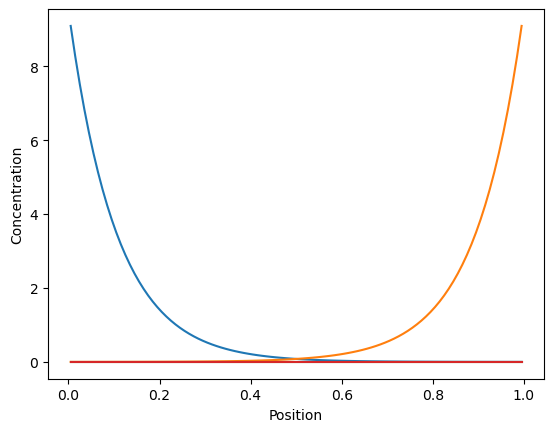

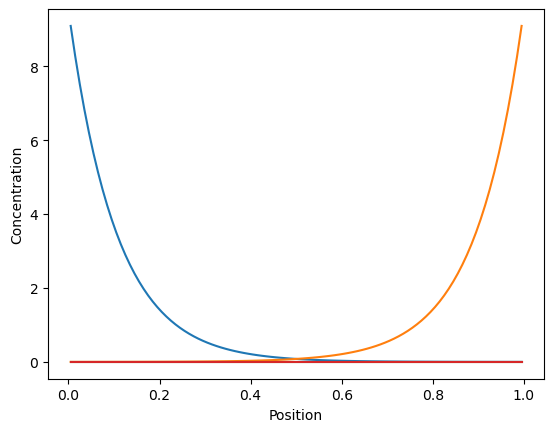

In [24]:
mrm_problem = CounterCurrent()
mrm_problem.solve(1)